### Best RF Model (With Hyperparamaeter, Smote, Binary Classification)

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import SpectralClustering
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error
from imblearn.over_sampling import SMOTE
from scipy.stats import randint

# Load dataset
df = pd.read_csv("student_sleep_patterns.csv")

# Split dataset
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Sleep_Quality'])

# Create 3-class category
bins = [df['Sleep_Quality'].min() - 1, 4, 7, df['Sleep_Quality'].max() + 1]
labels = [0, 1, 2]  # 0 = Low, 1 = Medium, 2 = High
train_df['Sleep_Quality_Category'] = pd.cut(train_df['Sleep_Quality'], bins=bins, labels=labels).astype(int)
test_df['Sleep_Quality_Category'] = pd.cut(test_df['Sleep_Quality'], bins=bins, labels=labels).astype(int)

# Merge into binary: 0 if Low or Medium, 1 if High
train_df['Sleep_Quality_Binary'] = train_df['Sleep_Quality_Category'].apply(lambda x: 1 if x == 2 else 0)
test_df['Sleep_Quality_Binary'] = test_df['Sleep_Quality_Category'].apply(lambda x: 1 if x == 2 else 0)

# Drop Student_ID if exists
for df_ in [train_df, test_df]:
    df_.drop(columns=[col for col in ['Student_ID'] if col in df_.columns], inplace=True)

# Encode categoricals
cat_cols = train_df.select_dtypes(include='object').columns
le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
    test_df[col] = test_df[col].map(lambda s: le.transform([s])[0] if s in le.classes_ else -1)
    le_dict[col] = le

# Separate features and binary target
X_train = train_df.drop(columns=['Sleep_Quality', 'Sleep_Quality_Category', 'Sleep_Quality_Binary'])
y_train = train_df['Sleep_Quality_Binary']
X_test = test_df.drop(columns=['Sleep_Quality', 'Sleep_Quality_Category', 'Sleep_Quality_Binary'])
y_test = test_df['Sleep_Quality_Binary']

# Scale features for clustering
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Spectral Clustering
n_clusters = 3
spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
train_clusters = spectral.fit_predict(X_train_scaled)

# Train RF to mimic clustering for test
rf_cluster = RandomForestClassifier(random_state=42, n_estimators=100)
rf_cluster.fit(X_train, train_clusters)
test_clusters = rf_cluster.predict(X_test)

# Add cluster as feature
X_train['Spectral_Cluster'] = train_clusters
X_test['Spectral_Cluster'] = test_clusters

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Random Forest setup
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None]
}

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring='accuracy'
)
random_search.fit(X_train_resampled, y_train_resampled)

# Best model
best_rf = random_search.best_estimator_
print(f"Best Hyperparameters: {random_search.best_params_}")

# Predictions on full feature set
y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)
print(f"Train Accuracy (all features): {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Test Accuracy (all features): {accuracy_score(y_test, y_test_pred):.4f}")

# Feature importance ranking
importances = best_rf.feature_importances_
features = X_train.columns
feat_imp_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Test accuracy for different k
test_accuracies = []
for k in range(1, len(features) + 1):
    top_features = feat_imp_df['Feature'].iloc[:k].tolist()
    rf_top = RandomForestClassifier(random_state=42, class_weight='balanced', **random_search.best_params_)
    rf_top.fit(X_train[top_features], y_train)
    y_test_pred_k = rf_top.predict(X_test[top_features])
    acc = accuracy_score(y_test, y_test_pred_k)
    test_accuracies.append(acc)

best_k = np.argmax(test_accuracies) + 1
print(f"\nBest number of features: {best_k} with Test Accuracy: {test_accuracies[best_k - 1]:.4f}")

# Final RF with best_k features
best_features = feat_imp_df['Feature'].iloc[:best_k].tolist()
X_train_best = X_train[best_features]
X_test_best = X_test[best_features]

final_rf = RandomForestClassifier(random_state=42, class_weight='balanced', **random_search.best_params_)
final_rf.fit(X_train[best_features], y_train)

y_train_pred_best = final_rf.predict(X_train[best_features])
y_test_pred_best = final_rf.predict(X_test[best_features])

# Evaluation
print(f"\nTrain Accuracy (best features): {accuracy_score(y_train, y_train_pred_best):.4f}")
print(f"Test Accuracy (best features): {accuracy_score(y_test, y_test_pred_best):.4f}")
print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred_best))
print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred_best))

# RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_best))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_best))
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Hyperparameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 13, 'n_estimators': 394}
Train Accuracy (all features): 0.9825
Test Accuracy (all features): 0.6500

Best number of features: 8 with Test Accuracy: 0.7400

Train Accuracy (best features): 0.9975
Test Accuracy (best features): 0.7400

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.75      0.96      0.84        71
           1       0.67      0.21      0.32        29

    accuracy                           0.74       100
   macro avg       0.71      0.58      0.58       100
weighted avg       0.72      0.74      0.69       100

Confusion Matrix (Test):
[[68  3]
 [23  6]]
Train RMSE: 0.0500
Test RMSE: 0.5099


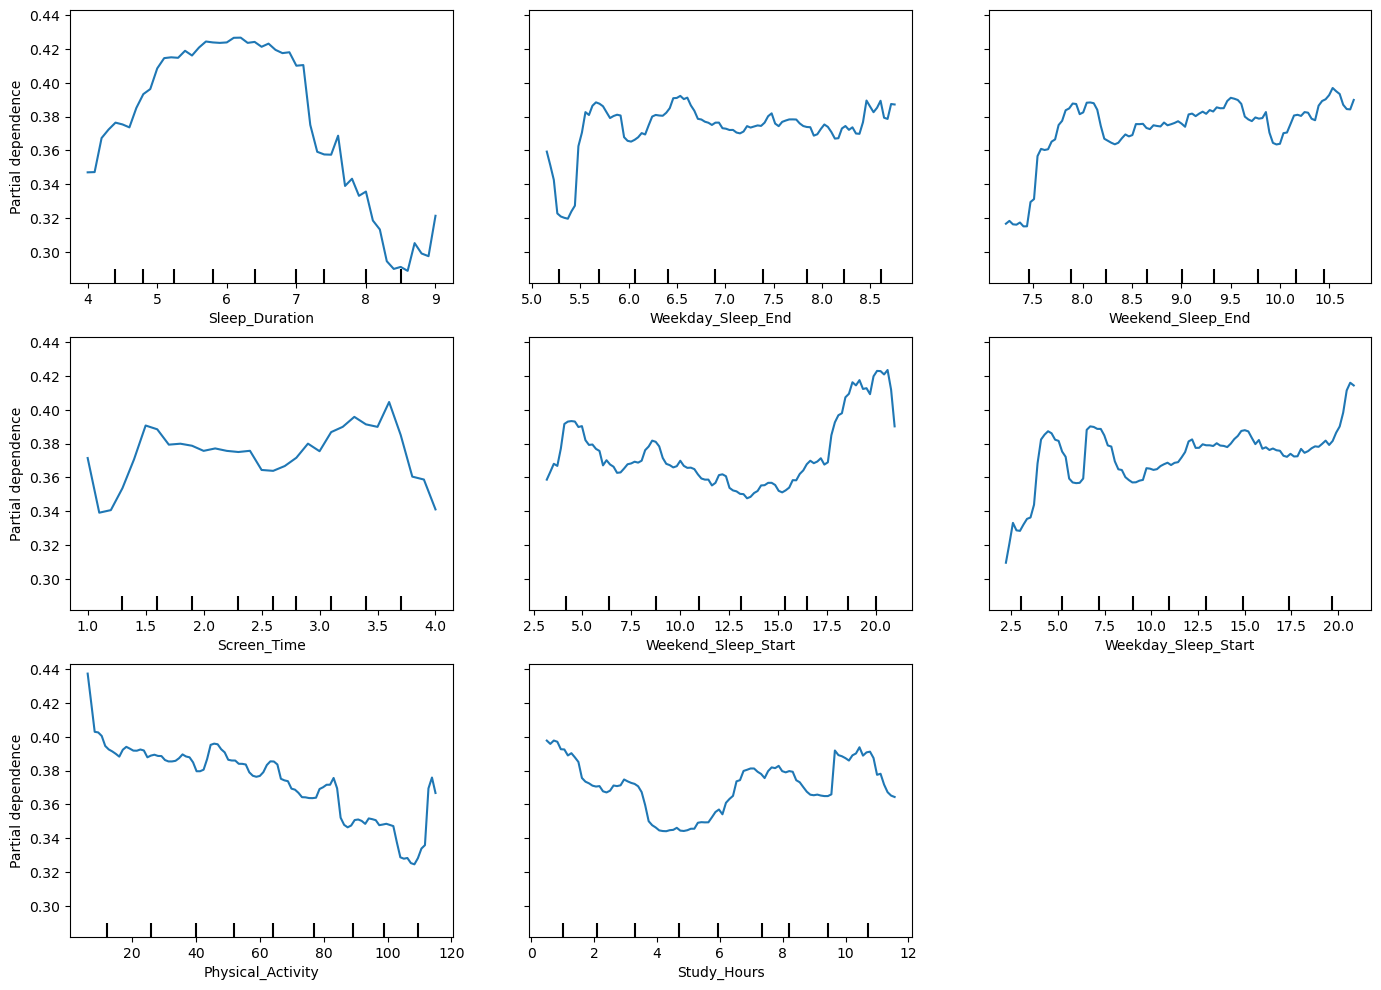

In [10]:
import os
from sklearn.inspection import PartialDependenceDisplay


trained_features = ['Sleep_Duration', 'Weekday_Sleep_End', 'Weekend_Sleep_End',
                    'Screen_Time', 'Weekend_Sleep_Start', 'Weekday_Sleep_Start',
                    'Physical_Activity', 'Study_Hours']

X_train_pdp = X_train_best[trained_features]

fig, ax = plt.subplots(figsize=(14, 10))
PartialDependenceDisplay.from_estimator(
    final_rf,
    X_train_pdp,
    features=trained_features,
    target=1,  # or whichever class you want
    ax=ax,
    kind='average'
)
plt.tight_layout()
plt.show()




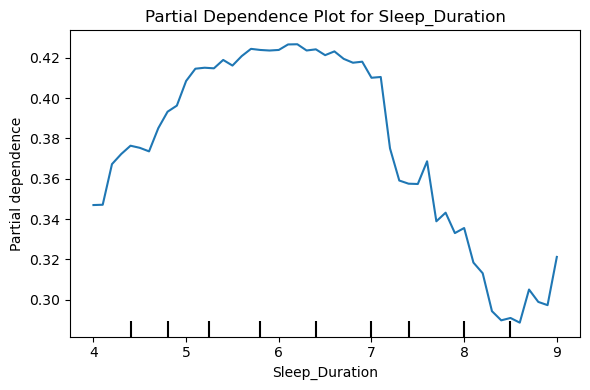

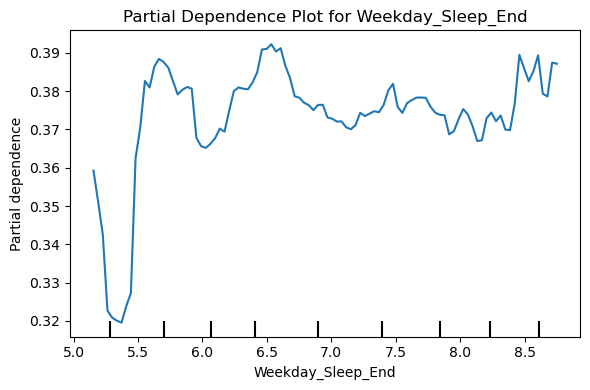

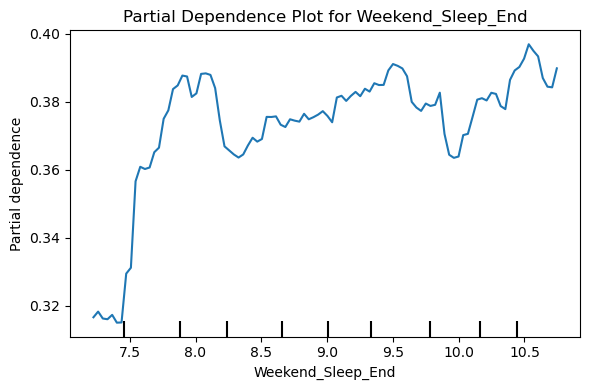

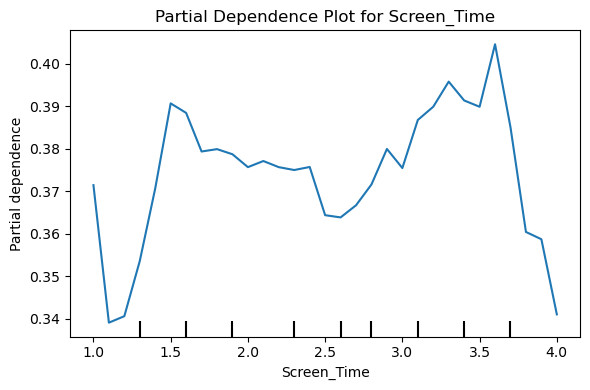

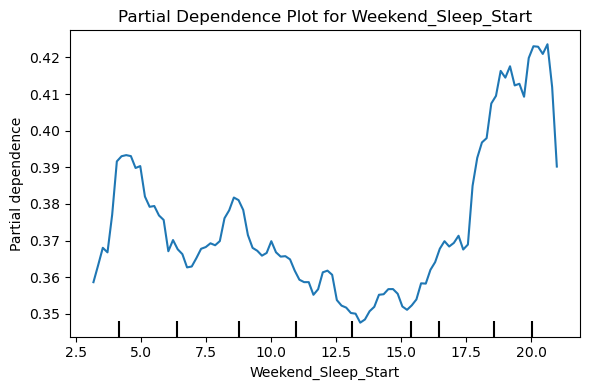

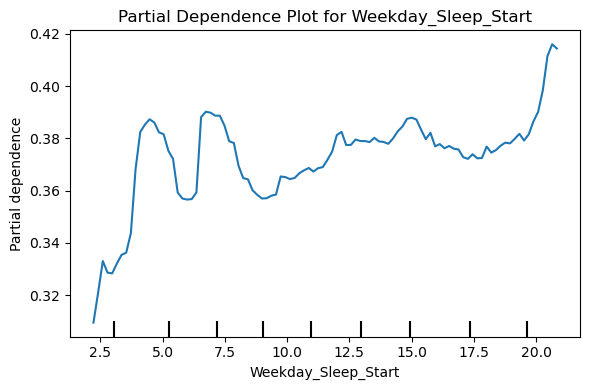

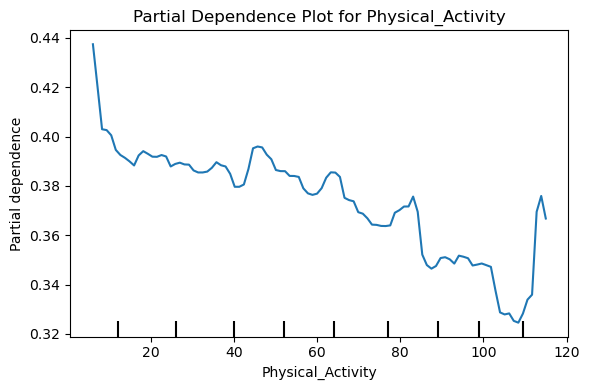

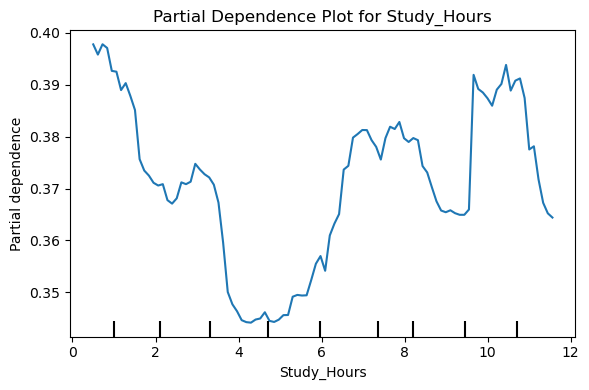

In [5]:
import os
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

trained_features = ['Sleep_Duration', 'Weekday_Sleep_End', 'Weekend_Sleep_End',
                    'Screen_Time', 'Weekend_Sleep_Start', 'Weekday_Sleep_Start',
                    'Physical_Activity', 'Study_Hours']

X_train_pdp = X_train_best[trained_features]

# Create folder if it doesn't exist
save_dir = 'presentation/pdp_plots'
os.makedirs(save_dir, exist_ok=True)

for feature in trained_features:
    fig, ax = plt.subplots(figsize=(6, 4))
    PartialDependenceDisplay.from_estimator(
        final_rf,
        X_train_pdp,
        features=[feature],
        target=0,  # change if you want a different class
        ax=ax,
        kind='average'
    )
    plt.title(f'Partial Dependence Plot for {feature}')
    plt.tight_layout()
    plt.show()

### Paritial dependencies

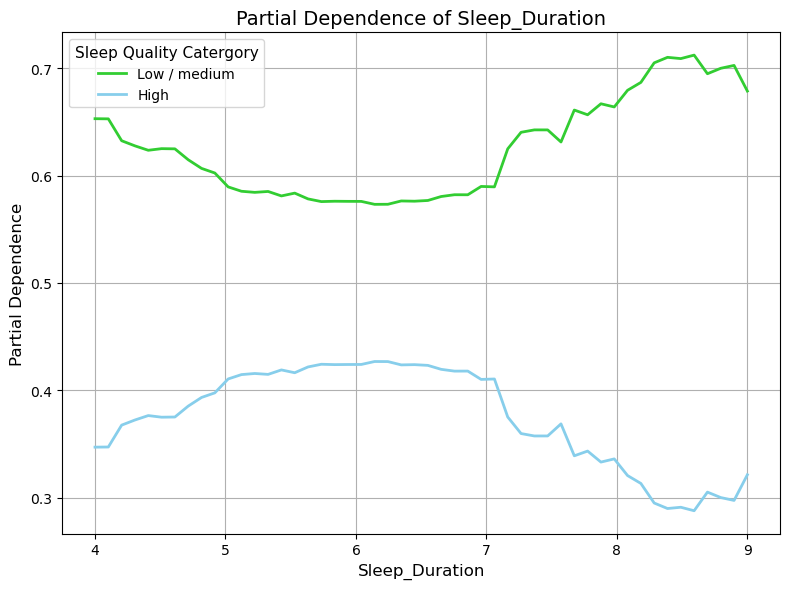

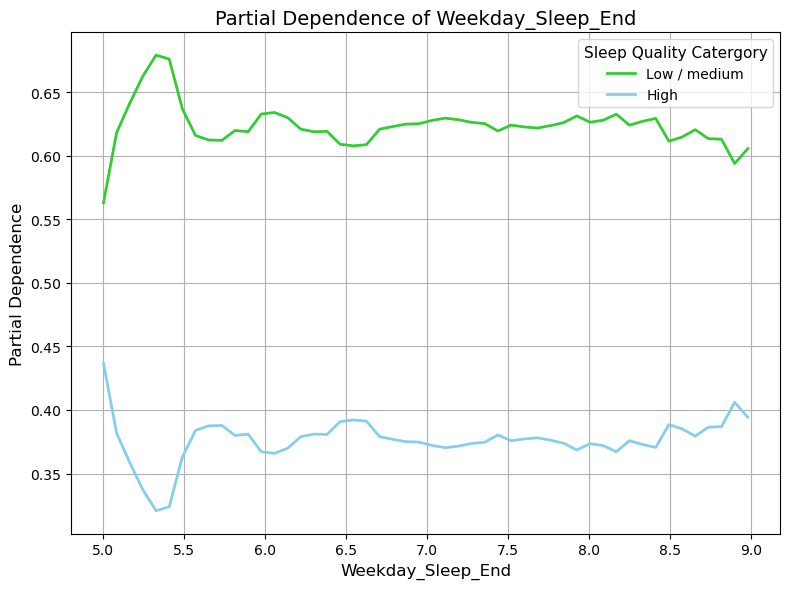

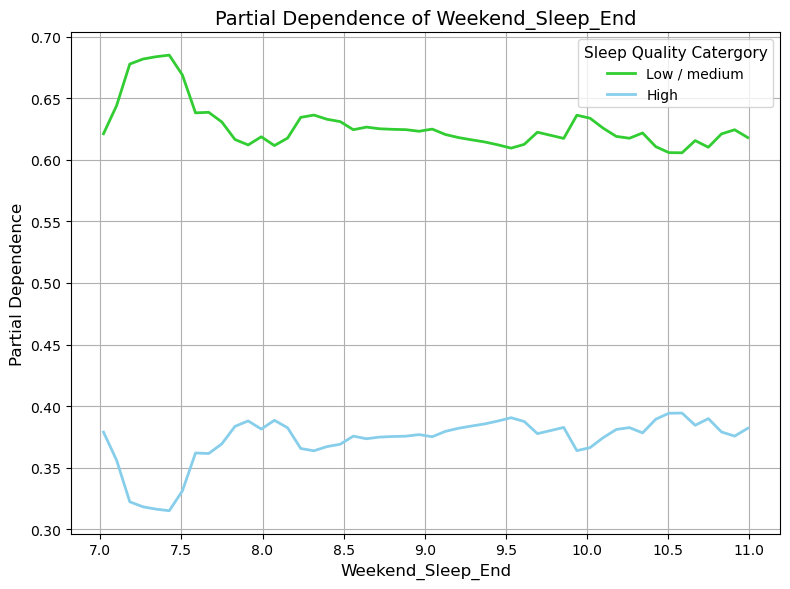

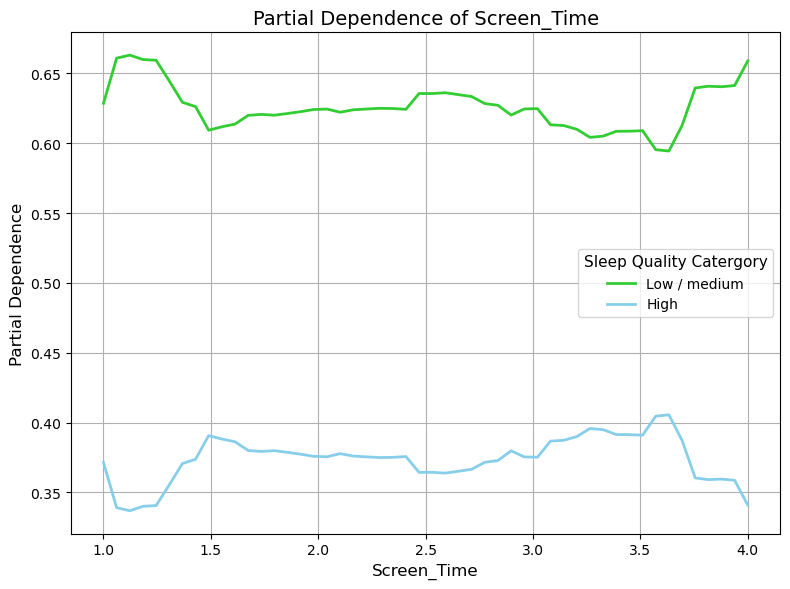

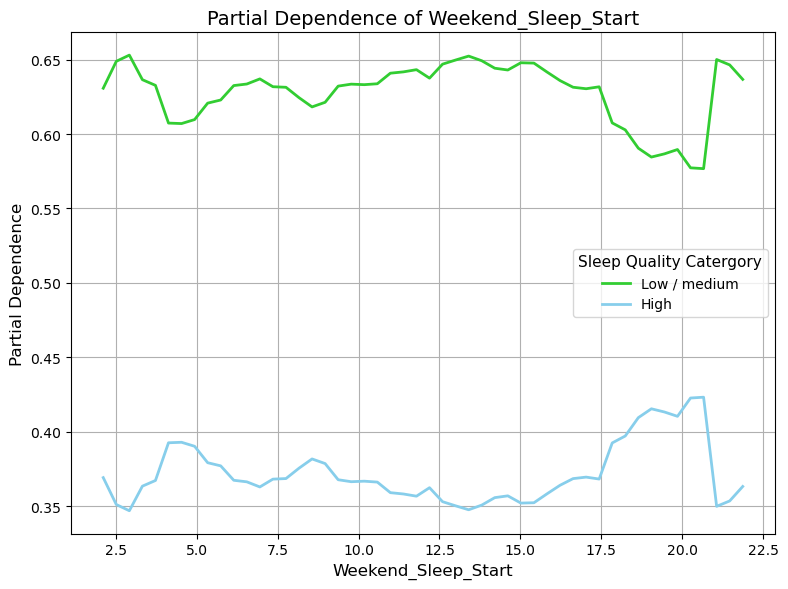

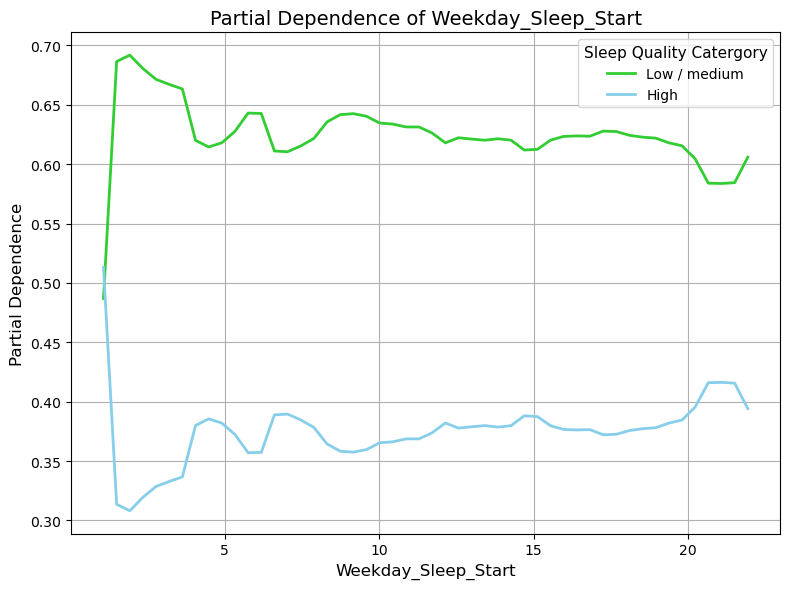

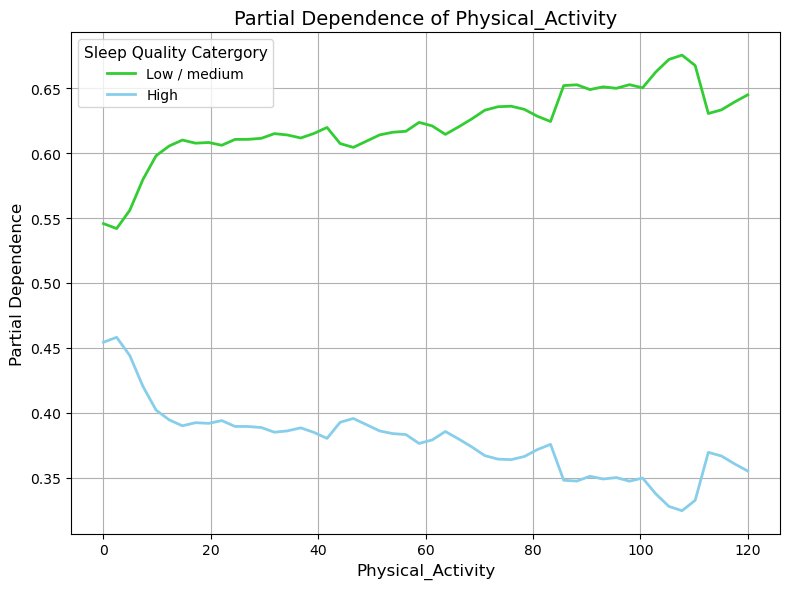

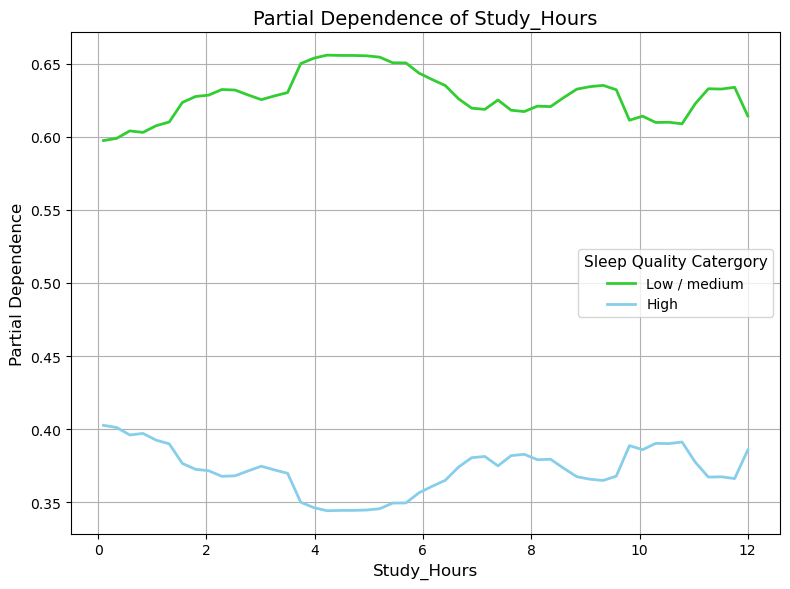

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Features you want PDPs for
features = ['Sleep_Duration', 'Weekday_Sleep_End', 'Weekend_Sleep_End', 'Screen_Time',
    'Weekend_Sleep_Start', 'Weekday_Sleep_Start', 'Physical_Activity', 'Study_Hours']

# Map class index to triage color labels
class_label_map = {
    0: 'Low / Medium',
    1: 'High'
}

# Color map for plotting
color_map = {
    'Low / Medium': 'limegreen',
    'High': 'skyblue',
}
# Filter and reorder your DataFrame
X_train_selected = X_train_best[features]

# Loop through each feature
for feature in features:
    plt.figure(figsize=(8, 6))
    grid = np.linspace(X_train_selected[feature].min(), X_train_selected[feature].max(), 50)

    for class_idx in range(len(class_label_map)):
        pd_values = []

        for val in grid:
            X_temp =X_train_selected.copy()
            X_temp[feature] = val
            proba = final_rf.predict_proba(X_temp)[:, class_idx]
            pd_values.append(np.mean(proba))

        label = class_label_map[class_idx]
        plt.plot(
            grid,
            pd_values,
            label=label.capitalize(),
            color=color_map[label],
            linewidth=2
        )

    plt.title(f'Partial Dependence of {feature}', fontsize=14)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Partial Dependence', fontsize=12)
    plt.legend(title='Sleep Quality Catergory', fontsize=10, title_fontsize=11)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig( f'pdp_{feature}.png')
    
    plt.show()

In [16]:
print(final_rf.classes_)


[0 1]
